In [1]:
using Random
using DataFrames
using Gadfly

include("SimpleAgentEvents/src/SimpleAgentEvents.jl")

using .SimpleAgentEvents
using .SimpleAgentEvents.Scheduler

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/martin/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
@enum Status susceptible infected immune dead

mutable struct Person
    status :: Status
    contacts :: Vector{Person}
    x :: Float64
    y :: Float64
end

Person(x, y) = Person(susceptible, [], x, y)
Person(state, x, y) = Person(state, [], x, y)

Person

In [3]:
mutable struct Simulation
    scheduler :: PQScheduler{Float64}
    inf :: Float64
    rec :: Float64
    imm :: Float64
    mort :: Float64
    
    pop :: Vector{Person}
end

scheduler(sim :: Simulation) = sim.scheduler

Simulation(i, r, u, m) = Simulation(PQScheduler{Float64}(), i, r, u, m, [])

Simulation

In [4]:
@processes SIRm sim person::Person begin
    @poisson(sim.inf * count(p -> p.status == infected, person.contacts)) ~
        person.status == susceptible        => 
            begin
                person.status = infected
                [person; person.contacts]
            end

    @poisson(sim.rec)  ~
        person.status == infected           => 
            begin
                person.status = susceptible
                [person; person.contacts]
            end

    @poisson(sim.imm)  ~
        person.status == infected           => 
            begin
                person.status = immune
                person.contacts
            end
    
    @poisson(sim.mort)  ~
        person.status == infected           => 
            begin
                person.status = dead
                person.contacts
            end    
end


spawn_SIRm (generic function with 1 method)

In [5]:
include("setup_world.jl")
include("draw.jl")

draw_sim (generic function with 3 methods)

In [6]:
function run_grid(inf, rec, imm, mort, x, y, tim, seed)
    sim = Simulation(inf, rec, imm, mort)
    sim.pop = setup_grid(x, y)
    sim.pop[1].status = infected


    for person in sim.pop
        spawn_SIRm(person, sim)
    end

    Random.seed!(seed)
    
    n_inf = Int[]
    n_susc = Int[]
    n_imm = Int[]
    n_dead = Int[]

    
    for t in  1:tim
        upto!(sim.scheduler, time_now(sim.scheduler) + 1.0)
        push!(n_inf, count(p -> p.status == infected, sim.pop))
        push!(n_susc, count(p -> p.status == susceptible, sim.pop))
        push!(n_imm, count(p -> p.status == immune, sim.pop))
        push!(n_dead, count(p -> p.status == dead, sim.pop))
    end
    
    DataFrame(inf = n_inf, susc = n_susc, imm = n_imm, dead = n_dead), sim
end


run_grid (generic function with 1 method)

In [7]:
# set near < 0.05!
function run_geograph(inf, rec, imm, mort, N, near, nc, tim, seed)
    sim = Simulation(inf, rec, imm, mort)
    sim.pop = setup_geograph(N, near, nc)
    sim.pop[1].status = infected

    for person in sim.pop
        spawn_SIRm(person, sim)
    end

    Random.seed!(seed)
    
    n_inf = Int[]
    n_susc = Int[]
    n_imm = Int[]
    n_dead = Int[]

    
    for t in  1:tim
        upto!(sim.scheduler, time_now(sim.scheduler) + 1.0)
        push!(n_inf, count(p -> p.status == infected, sim.pop))
        push!(n_susc, count(p -> p.status == susceptible, sim.pop))
        push!(n_imm, count(p -> p.status == immune, sim.pop))
        push!(n_dead, count(p -> p.status == dead, sim.pop))
    end
    
    DataFrame(inf = n_inf, susc = n_susc, imm = n_imm, dead = n_dead), sim
end


run_geograph (generic function with 1 method)

In [8]:
data, sim = run_grid(0.3, 0.1, 0.2, 0.1, 50, 50, 100, 42);

In [9]:
data2, sim2 = run_geograph(0.3, 0.1, 0.2, 0.1, 2500, 0.03, 100, 100, 42);

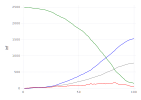

In [22]:
plot(data, layer(y=:inf, Geom.line, Theme(default_color="red")),
    layer(y=:susc, Geom.line, Theme(default_color="green")),
    layer(y=:imm, Geom.line, Theme(default_color="blue")),
    layer(y=:dead, Geom.line, Theme(default_color="grey")))
    

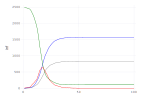

In [24]:
plot(data2, layer(y=:inf, Geom.line, Theme(default_color="red")),
    layer(y=:susc, Geom.line, Theme(default_color="green")),
    layer(y=:imm, Geom.line, Theme(default_color="blue")),
    layer(y=:dead, Geom.line, Theme(default_color="grey")))